In [1]:
import os
import io
import sys
import glob
import warnings
import scipy.signal

import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
import peakutils

from shapely.geometry import Point
from matplotlib import pyplot
from github import Github


sys.path.append('../')
warnings.filterwarnings('ignore', category=UserWarning)

### Data

In [2]:
git = Github(os.getenv('GH_TOKEN'))
repo = git.get_repo('pr0nstar/covid19-data')

##### Geocodes

In [3]:
COUNTRIES_FILE = repo.get_contents('update/geocodes.csv')
COUNTRIES = pd.read_csv(io.BytesIO(COUNTRIES_FILE.decoded_content))

COUNTRIES['geoCode'] = COUNTRIES['geoCode'].apply(
    lambda _: ('PY-0' + _[-1]) if (_.startswith('PY-') and len(_) == 4) else _
)
COUNTRIES = COUNTRIES.set_index(['country', 'geoName']).drop('geo', axis=1)['geoCode']

countries_df = COUNTRIES.reset_index().set_index('geoCode')

In [4]:
COUNTRIES.index.get_level_values(0).unique()

Index(['Bolivia', 'Brasil', 'Peru', 'Chile', 'Argentina', 'Paraguay',
       'Ecuador', 'Colombia', 'Venezuela', 'Uruguay'],
      dtype='object', name='country')

##### GTrends

In [5]:
def unpickle_data():
    country_data = {}

    for country_path in repo.get_contents('raw/google/trends'):
        country_name = os.path.basename(country_path.path)
        country = {}

        for dept_path in repo.get_contents(country_path.path):
            dept_name = os.path.basename(dept_path.path)
            dept_name = dept_name.rsplit('.', 1)[0]
            
            dept_df = pd.read_csv(dept_path.download_url, index_col=0)
            dept_df.columns = pd.to_datetime(dept_df.columns)

            country[dept_name] = dept_df.T

        country_data[country_name] = country

    return country_data

In [6]:
country_data = unpickle_data()
country_data['Bolivia']['Tarija Department'].tail(1)

,0,1,2,3,4,5,6,7,8,9,...,396,397,398,399,400,401,402,403,404,405
2021-10-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,7.5,13.75,0.0,26.5,9.0,35.25


In [7]:
trends_df = pd.DataFrame([])

for country in country_data.keys():
    country_dict = {
        _:(100 * __ / __.max()).mean(axis=1) for _, __ in country_data[country].items()
    }
    country_df = pd.DataFrame(country_dict)
    country_df.columns = pd.MultiIndex.from_product([[country], country_df.columns])
    
    trends_df = pd.concat([trends_df, country_df], axis=1)

In [8]:
trends_df = trends_df.rolling(window=2).mean().dropna(how='all')
trends_df = trends_df.apply(lambda _: 100 * _ / _.max())

trends_df = trends_df.T
trends_df = trends_df.loc[trends_df.idxmax(axis=1).sort_values(ascending=False).index]

trends_df.columns = trends_df.columns + pd.Timedelta(weeks=1)

trends_df.head(1)

,,2020-03-15,2020-03-22,2020-03-29,2020-04-05,2020-04-12,2020-04-19,2020-04-26,2020-05-03,2020-05-10,2020-05-17,...,2021-08-29,2021-09-05,2021-09-12,2021-09-19,2021-09-26,2021-10-03,2021-10-10,2021-10-17,2021-10-24,2021-10-31
Colombia,Arauca,0.0,24.895339,45.765619,41.26287,20.392589,0.0,22.26944,24.60318,17.2625,33.861717,...,6.978895,14.747908,18.278007,14.633421,4.124427,0.0,0.0,23.306987,23.306987,0.0


In [9]:
dtrends_df = pd.DataFrame([])

for country_name in COUNTRIES.index.get_level_values(0).unique():
    ctrends_df = trends_df.loc[country_name]
    ctrends_df.index = COUNTRIES[country_name][
        trends_df.loc[country_name].index
    ].values
    
    dtrends_df = pd.concat([dtrends_df, ctrends_df])
    
dtrends_df = dtrends_df.T['2020-03-29':]
dtrends_df = (dtrends_df / 100).round(1)

dtrends_df[dtrends_df == 0] = 5e-2

dtrends_df.tail(1)

,BO-P,BO-H,BO-T,BO-O,BO-L,BO-C,BO-S,BO-B,BR-SP,BR-MG,...,UY-LA,UY-CL,UY-TT,UY-MO,UY-AR,UY-SJ,UY-MA,UY-TA,UY-RV,UY-FS
2021-10-31,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.05,0.1,0.1,...,0.3,0.05,0.05,0.2,0.1,0.05,0.1,0.05,0.2,0.7


##### PAHO

In [10]:
paho_dir = repo.get_contents('raw/paho')
cases_file = {
    os.path.basename(_.path): _ for _ in paho_dir
}['confirmed.timeline.csv']

cases_df = pd.read_csv(
    cases_file.download_url,
    header=[0, 1], index_col=[0]
)
cases_df.index = pd.to_datetime(cases_df.index)
cases_df = cases_df.droplevel(0, axis=1)
cases_df = cases_df.unstack()

cases_df.head(1)

ADM1_ISOCODE  DATA_DATE 
AW-01         2020-01-21   NaN
dtype: float64

##### Mortalidad

In [11]:
mortality_dir = repo.get_contents('raw/mortality')
mortality_file = {
    os.path.basename(_.path): _ for _ in mortality_dir
}['south.america.subnational.mortality.csv']

mortality_df = pd.read_csv(mortality_file.download_url)
mortality_df['date'] = pd.to_datetime(mortality_df['date'])
mortality_df = mortality_df.set_index(['adm1_isocode', 'date'])

# ...
geo_codes = {'PY-{}'.format(_):'PY-0{}'.format(_) for _ in range(1, 10)}
geo_codes['PE-LMA'] = 'PE-LIM'

mortality_df = mortality_df.rename(geo_codes)
mortality_df.head(1)

,,iso_code,country_name,adm1_name,frequency,deaths
adm1_isocode,date,,,,,
BO-B,2019-01-01,BO,Bolivia,Beni,monthly,131


### Mapa

In [12]:
# https://www.geoboundaries.org/
gdf = gpd.read_file('../update/geoBoundariesCGAZ_SA_ADM1.geojson')
gdf = gdf.set_index('shapeISO')

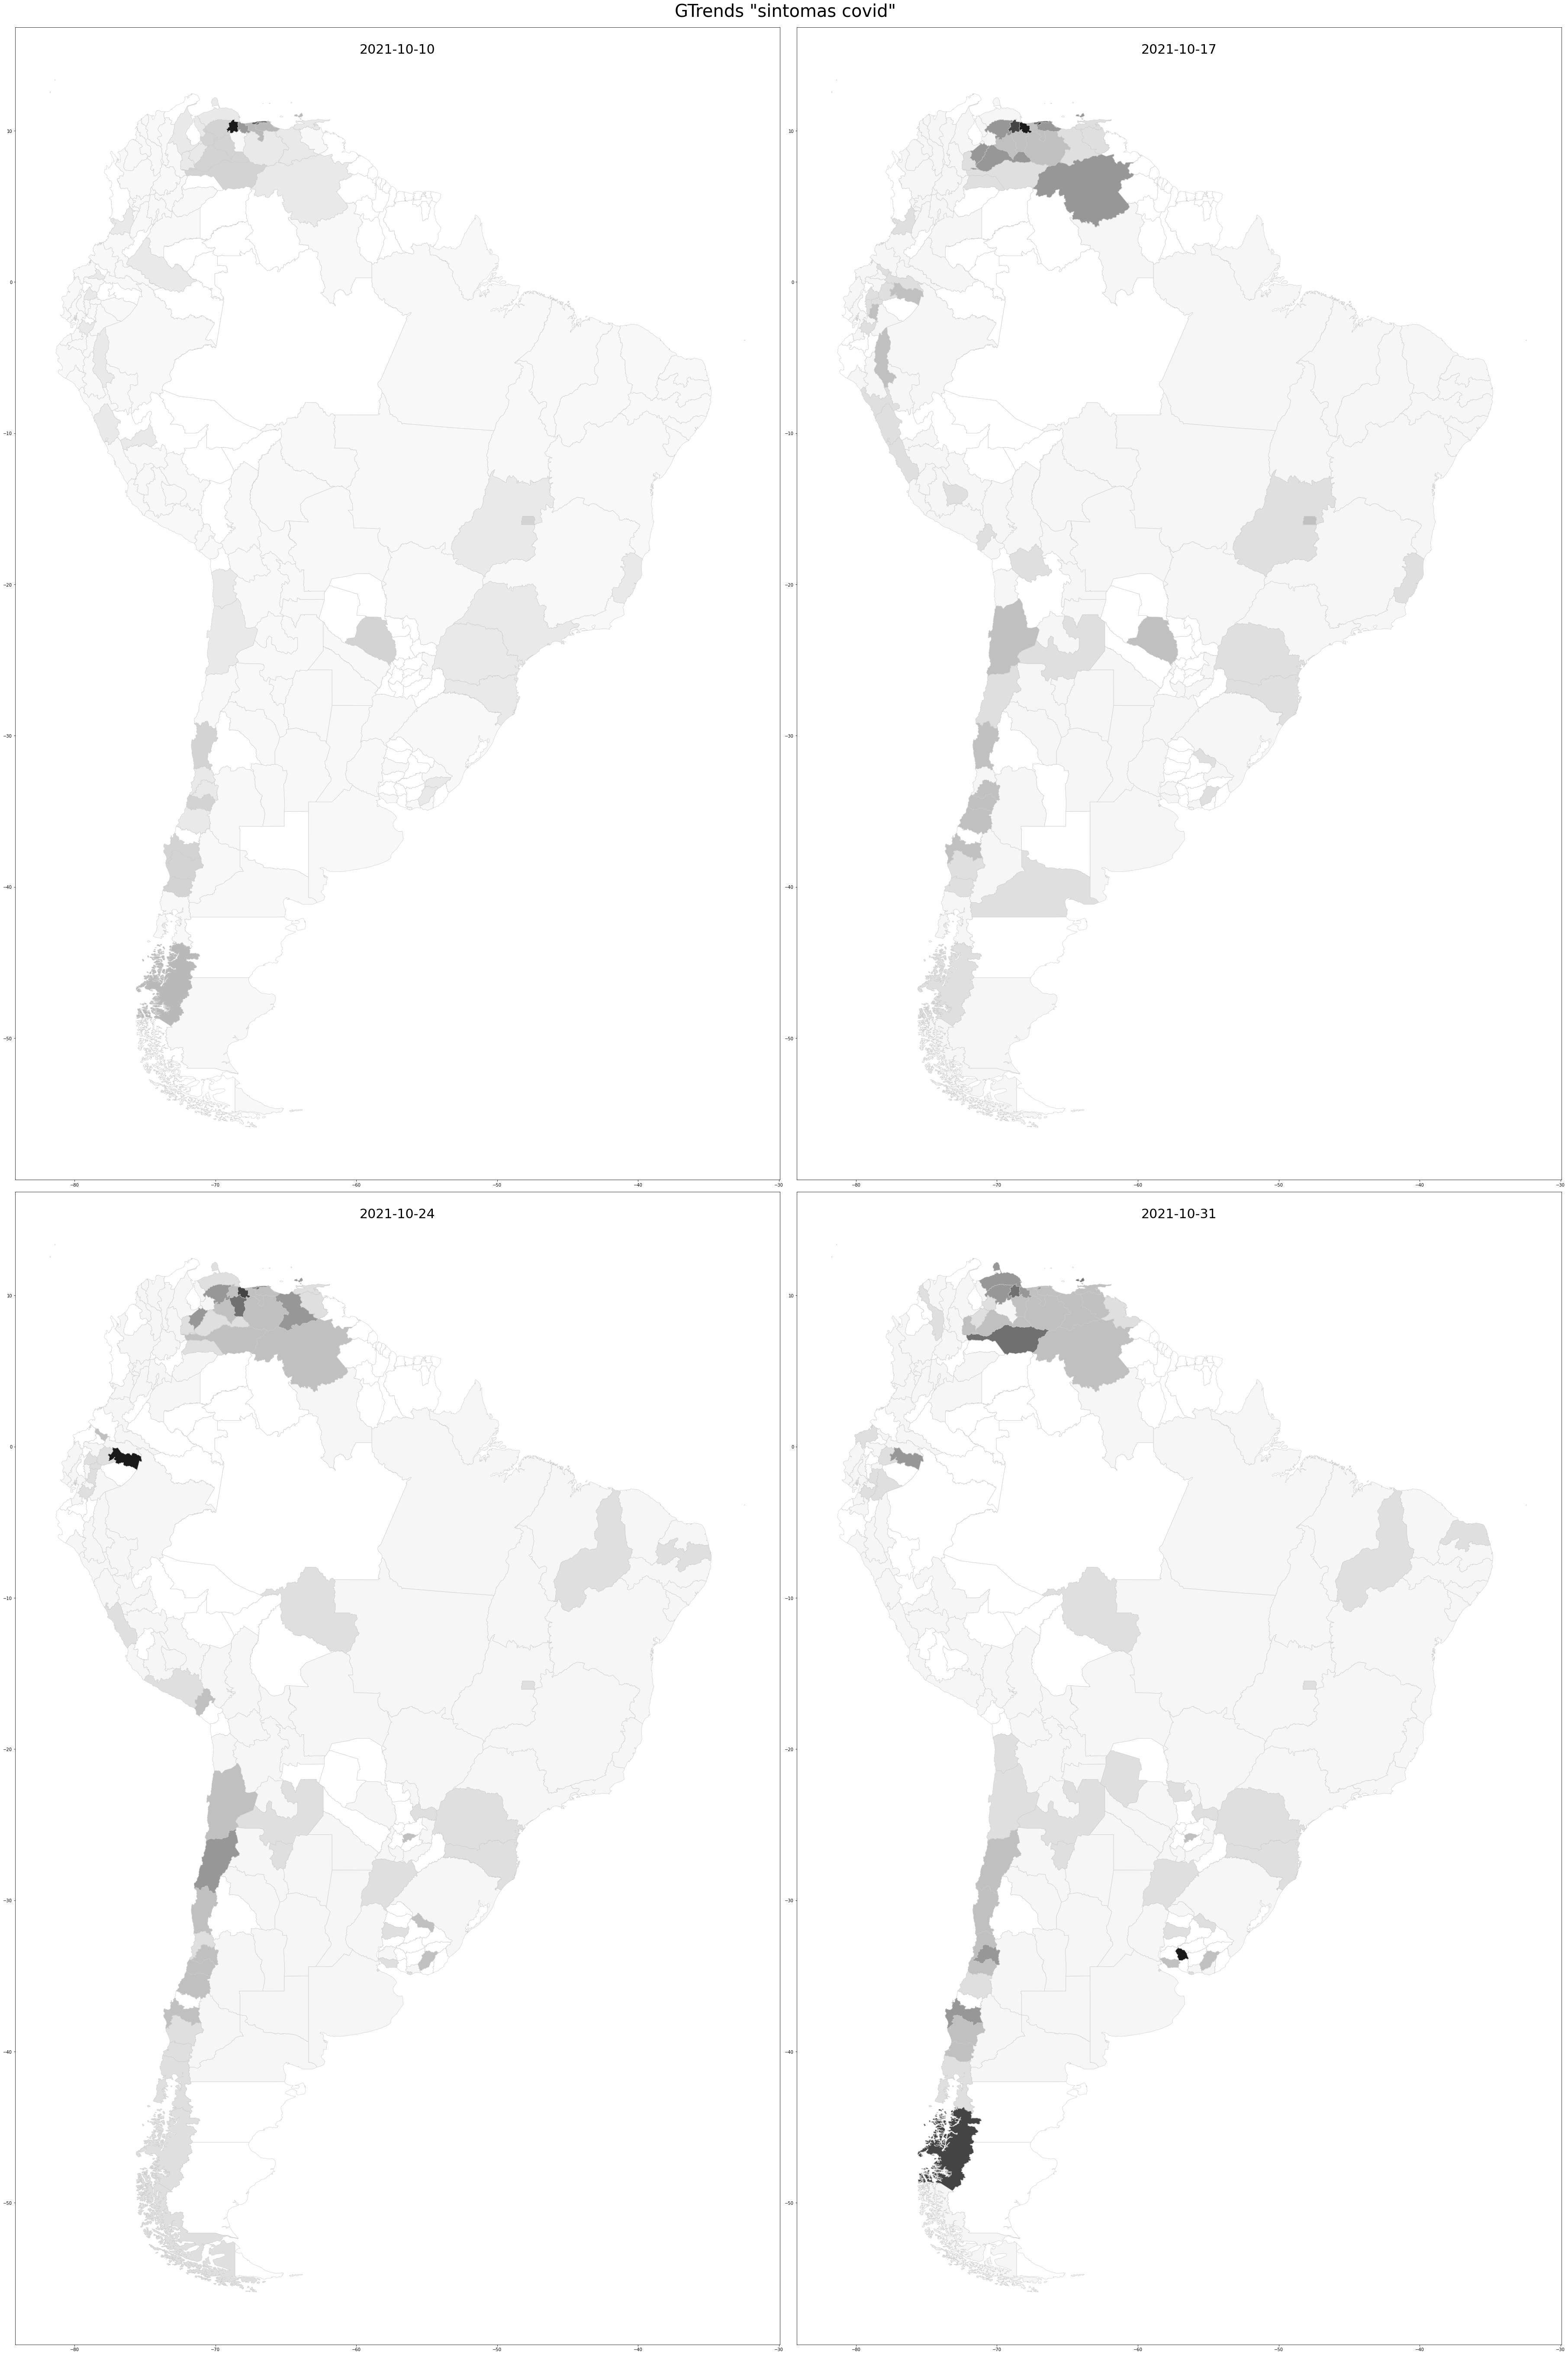

In [13]:
plot_df = dtrends_df.iloc[-4:]
nrows = int(np.ceil(len(plot_df) / 2))

fig, axs = pyplot.subplots(
    ncols=2, nrows=nrows,
    figsize=(128/2.54, (96 * nrows)/2.54),
)
axs = axs.flatten()

for idx, (date, date_trend) in enumerate(plot_df.iterrows()):
    gdf['trend'] = date_trend
    gdf['trend'] = gdf['trend'].fillna(5e-2)

    ax = gdf.plot(
        column='trend',
        cmap='Greys',
        alpha=.9,
        linewidth=0.8,
        edgecolor='0.8',
        ax=axs[idx]
    )
    ax.set_title(str(date)[:10], y=.975, fontdict={'fontsize': 30})
    
    extent = ax.get_tightbbox(fig.canvas.renderer).transformed(
        fig.dpi_scale_trans.inverted()
    )

fig.set_tight_layout(True)
fig.suptitle('GTrends "sintomas covid"', fontsize=40, y=.999)
fig.savefig('../img/gtrends.jpg', bbox_inches='tight')

#### Comparativo

In [14]:
# Align Colombia
mortality_df_t = mortality_df.set_index('iso_code', append=True)
mortality_df_t = mortality_df_t.swaplevel(0, 2, 0)
mortality_df_t = mortality_df_t.swaplevel(1, 2, 0)

mortality_df_co = mortality_df_t.loc[['CO']].reset_index(level='date')
mortality_df_co['date'] = mortality_df_co['date'] - pd.DateOffset(days=1)
mortality_df_co = mortality_df_co.set_index('date', append=True)

mortality_df_t = mortality_df_t.drop('CO')
mortality_df_t = pd.concat([mortality_df_t, mortality_df_co])

In [15]:
covid_mortality_df = pd.DataFrame([])
today = pd.to_datetime('today').round('d')

for iso_code, country_mortality_df in mortality_df_t.groupby(level='iso_code'):
    country_mortality_df = country_mortality_df.droplevel('iso_code')
    country_data_freq = country_mortality_df['frequency'].iloc[0]

    if country_data_freq == 'daily':
        country_mortality_df = country_mortality_df.groupby([
            pd.Grouper(level='adm1_isocode'),
            pd.Grouper(level='date', freq='D')
        ])['deaths'].mean()
        country_mortality_df = country_mortality_df.interpolate('linear')
        country_mortality_df = country_mortality_df.unstack(level=0)
        country_mortality_df = country_mortality_df.resample('W').sum()

    elif country_data_freq == 'monthly':
        country_mortality_df = country_mortality_df['deaths'].unstack(level=0)
        country_mortality_df_index = country_mortality_df.index[0]
        country_mortality_df.index = country_mortality_df.index + pd.DateOffset(months=1, days=-1)
        country_mortality_df.loc[country_mortality_df_index - pd.DateOffset(days=2)] = 0
        country_mortality_df = country_mortality_df.sort_index()
        
        if country_mortality_df.index[-1] > today:
            country_mortality_df = country_mortality_df.rename(
                index={country_mortality_df.index[-1]: today - pd.DateOffset(days=1)}
            )
        
        country_mortality_df = country_mortality_df.cumsum().asfreq('d')
        country_mortality_df = country_mortality_df.interpolate('pchip')
        country_mortality_df = country_mortality_df.diff().dropna().resample('W').sum()

    else:
        country_mortality_df = country_mortality_df['deaths'].unstack(level=0)
        
    covid_mortality_df = pd.concat([
        covid_mortality_df, country_mortality_df
    ], axis=1)

In [16]:
covid_mortality_df = (covid_mortality_df - covid_mortality_df.loc[:'2019'].mean())
covid_mortality_df = covid_mortality_df.loc[dtrends_df.index[0]:].iloc[:-4]
covid_mortality_df[covid_mortality_df < 0] = 0

covid_mortality_df = covid_mortality_df / covid_mortality_df.max()
covid_mortality_df = covid_mortality_df.round(2)

### Mapa de calor 

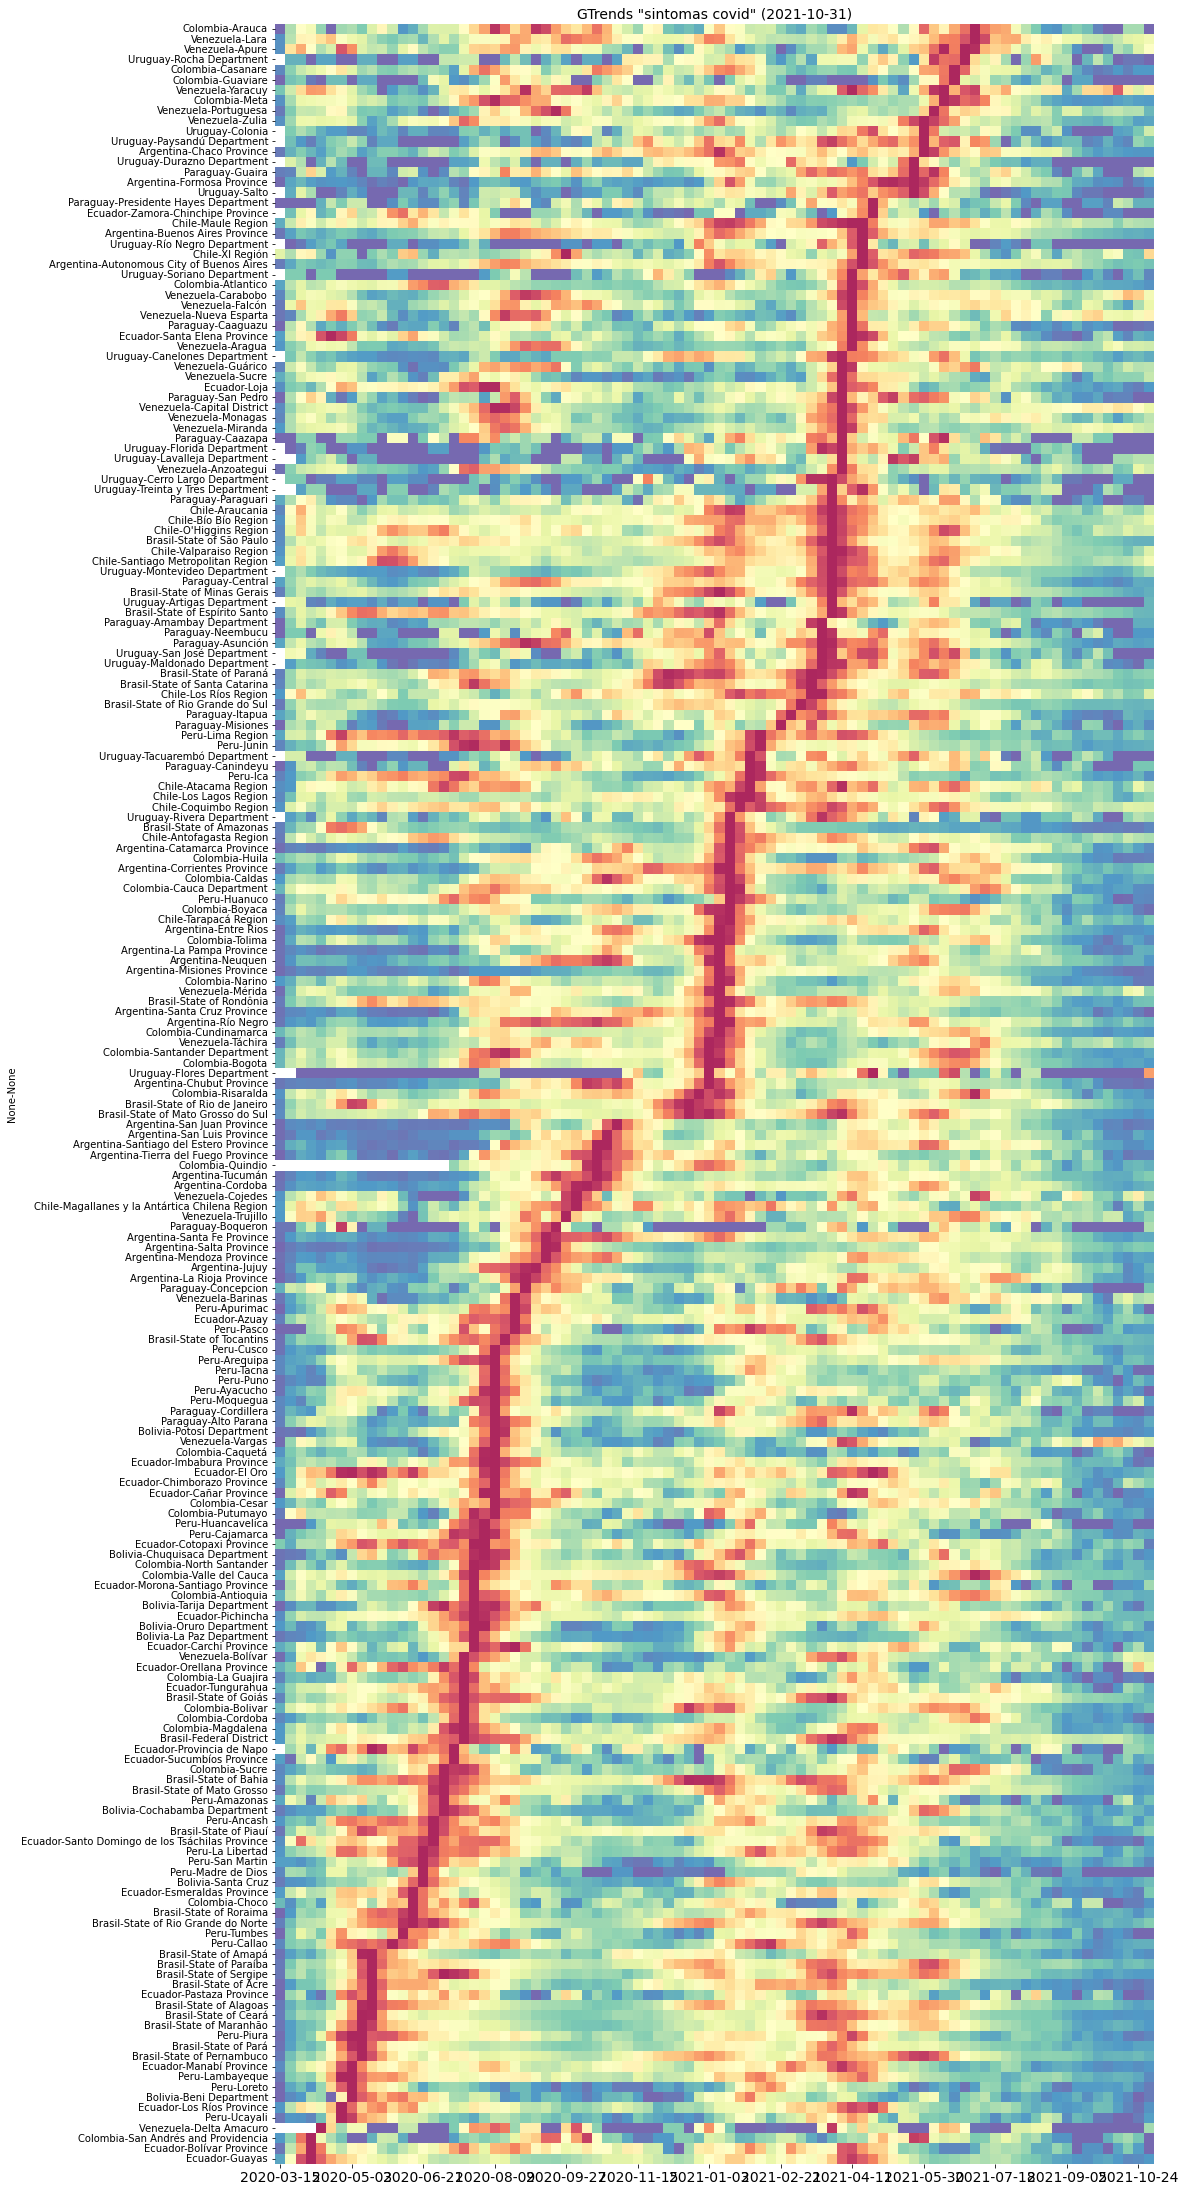

In [17]:
fig = pyplot.figure(
    figsize=(40 / 2.54, 100 / 2.54), facecolor='white'
)

ax = sns.heatmap(
    trends_df ** .9, cmap='Spectral_r', cbar=False, alpha=.85,
)
ax.set_title(
    'GTrends "sintomas covid" ({})'.format(str(trends_df.columns[-1])[:10]),
    fontsize=14
)

xticks = ax.get_xticks()
xticks = np.arange(0.5, xticks[-1], 7)

ax.set_xticks(xticks)
al = ax.set_xticklabels([
    column.date() for column in trends_df.iloc[:, xticks].columns
], rotation=0, fontsize=14)

### Casos

In [18]:
BO_ORDER = [
    'La Paz Department',
    'Cochabamba Department',
    'Santa Cruz',
    'Oruro Department',
    'Potosi Department',
    'Tarija Department',
    'Chuquisaca Department',
    'Beni Department',
]

In [19]:
country = 'Bolivia'
country_df = countries_df[countries_df['country'] == country]['geoName']

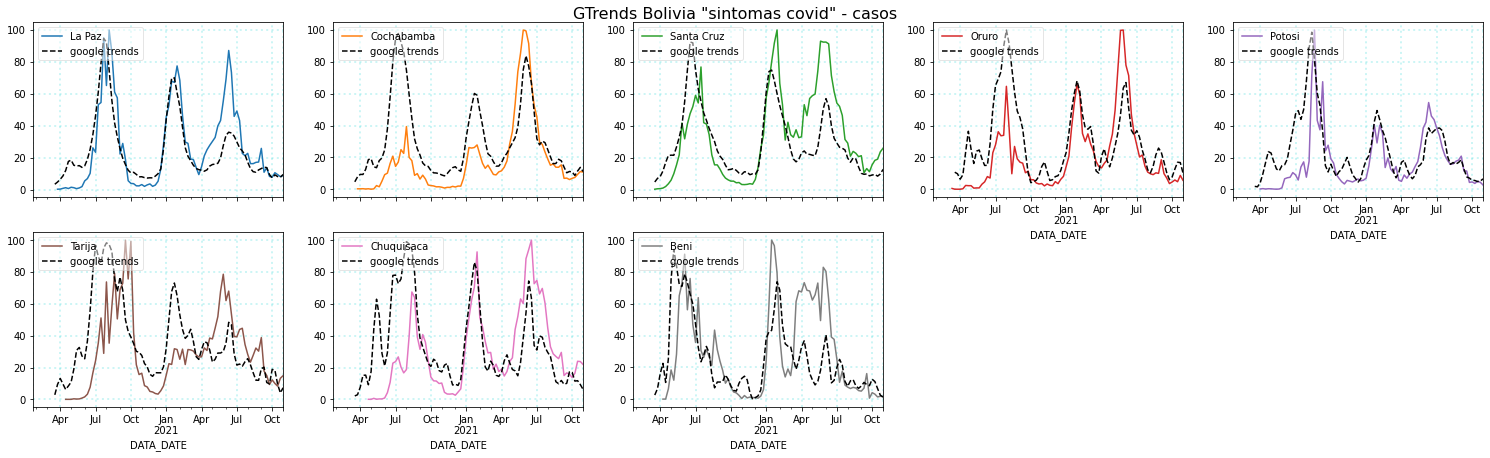

In [20]:
country_trends_df = trends_df.loc[country].T
country_trends_df = country_trends_df.rolling(window=2).mean().iloc[1:]

if country == 'Bolivia':
    country_trends_df = country_trends_df[BO_ORDER]

country_cases_df = cases_df.loc[country_df.index]
country_cases_df = country_cases_df.groupby([
    pd.Grouper(level='ADM1_ISOCODE'),
    pd.Grouper(level='DATA_DATE', freq='D')
]).mean().interpolate('linear').unstack(level=0)

country_cases_df = country_cases_df.sort_index()
country_cases_df = country_cases_df.rename(country_df.to_dict(), axis=1)

country_cases_df[country_cases_df.diff() < 1] = np.nan

country_cases_df = country_cases_df.interpolate('linear')
country_cases_df = country_cases_df.diff()

country_cases_df[country_cases_df < 0] = np.nan

country_cases_df = country_cases_df.resample('W').mean()
country_cases_df = (100 *  country_cases_df / country_cases_df.max())

country_cases_df = country_cases_df.loc[:country_trends_df.index[-1]]
country_cases_df = country_cases_df[country_trends_df.columns]
country_cases_df.columns = country_cases_df.columns.str.replace(
    ' Department', ''
).str.replace(' Province', '')

nrows = int(np.ceil(len(country_trends_df.columns) / 5))
axs = country_cases_df.plot(
    subplots=True, 
    figsize=(66/2.54, 9 * nrows/2.54), 
    layout=(nrows, 5)
)
axs = axs.flatten()[:len(country_cases_df.columns)]
axs = country_trends_df.plot(subplots=True, ax=axs, linestyle='--', color='black')

fig = axs[0].get_figure()
fig.suptitle(
    'GTrends {} "sintomas covid" - casos'.format(country), fontsize=16, y=.91
)

for idx, ax in enumerate(axs):
    dashed = ax.get_lines()[:2]
    
    if not dashed:
        continue

    ax.legend(
        dashed, [
            dashed[0].get_label(),
            'google trends'
        ], 
        loc='upper left',
        framealpha=.5
    )

    ax.grid(b=True, color='DarkTurquoise', alpha=0.2, linestyle=':', linewidth=2)
    
    current_data_df = country_trends_df.iloc[:, idx].dropna()
    base_df = peakutils.baseline(current_data_df, 5)
    
    debased_df = current_data_df - base_df
    debased_df = 100 * debased_df / debased_df.max()
    
#     peaks = peakutils.indexes(current_data_df - base_df, thres=0.4, min_dist=8)
#     [ax.axvline(current_data_df.index[peak], linestyle=':', color='grey') for peak in peaks]

fig.savefig('../img/gtrends.{}.jpg'.format(country), bbox_inches='tight')

### Mortalidad

In [21]:
country = 'Bolivia'
country_df = countries_df[countries_df['country'] == country]['geoName']

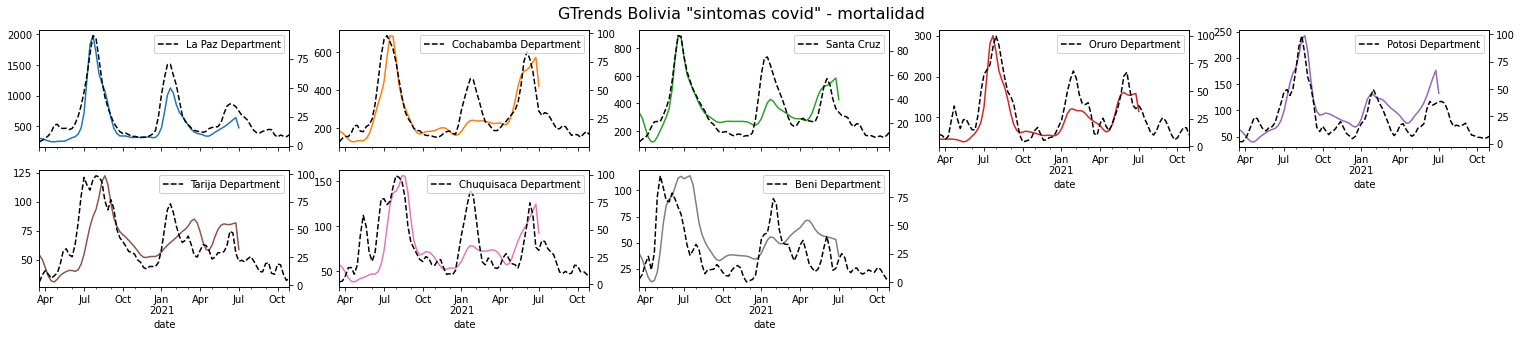

In [22]:
country_trends_df = trends_df.loc[country].T
country_trends_df = country_trends_df.rolling(window=2).mean().iloc[1:]

if country == 'Bolivia':
    country_trends_df = country_trends_df[BO_ORDER]

country_mortality_df = mortality_df.loc[country_df.index]
country_data_freq = country_mortality_df['frequency'].iloc[0]
today = pd.to_datetime('today').round('d')

if country_data_freq == 'daily':
    country_mortality_df = country_mortality_df.groupby([
        pd.Grouper(level='adm1_isocode'),
        pd.Grouper(level='date', freq='D')
    ])['deaths'].mean()
    country_mortality_df = country_mortality_df.interpolate('linear')
    country_mortality_df = country_mortality_df.unstack(level=0)
    country_mortality_df = country_mortality_df.resample('W').sum()
    
elif country_data_freq == 'monthly':
    country_mortality_df = country_mortality_df['deaths'].unstack(level=0)
    country_mortality_df_index = country_mortality_df.index[0]
    country_mortality_df.index = country_mortality_df.index + pd.DateOffset(months=1, days=-1)
    country_mortality_df.loc[country_mortality_df_index - pd.DateOffset(days=2)] = 0
    country_mortality_df = country_mortality_df.sort_index()

    if country_mortality_df.index[-1] > today:
        country_mortality_df = country_mortality_df.rename(
            index={country_mortality_df.index[-1]: today - pd.DateOffset(days=1)}
        )

    country_mortality_df = country_mortality_df.cumsum().asfreq('d')
    country_mortality_df = country_mortality_df.interpolate('pchip')
    country_mortality_df = country_mortality_df.diff().dropna().resample('W').sum()

    
else:
    country_mortality_df = country_mortality_df['deaths'].unstack(level=0)

country_mortality_df = country_mortality_df.rename(country_df.to_dict(), axis=1)
country_mortality_df = country_mortality_df.rolling(window=2).mean()

# country_mortality_df = 100 * country_mortality_df / country_mortality_df.max()
country_mortality_df = country_mortality_df[trends_df.columns[0]:trends_df.columns[-1]]
country_mortality_df = country_mortality_df[country_trends_df.columns]

nrows = int(np.ceil(len(country_mortality_df.columns) / 5))
# nrows = int(len(country_mortality_df.columns))
axs = country_mortality_df.plot(
    subplots=True, 
    figsize=(66/2.54, 6 * nrows/2.54), 
#     logy=True,
    layout=(nrows, 5)
)
axs = axs.flatten()[:len(country_trends_df.columns)]
axs = country_trends_df.plot(
    subplots=True, 
    ax=[_.twinx() for _ in axs], 
    linestyle='--', 
    color='black'
)

fig = axs[0].get_figure()
fig.suptitle(
    'GTrends {} "sintomas covid" - mortalidad'.format(country), fontsize=16, y=.95
)
fig.savefig('../img/gtrends.mortality.{}.jpg'.format(country), bbox_inches='tight')